# Stock Market Predictor

## Data Preprocessing

#### Importing Dependencies

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Importing the datasets


In [124]:
stockdata = pd.read_csv('final.csv')
#Date = stockdata.Date
#filling missing values
stockdata = stockdata.fillna(method ='pad')
count = stockdata.isnull().sum()
plotdata = stockdata
stockdata = stockdata.reset_index()['Close']

Text(0, 0.5, 'Closing Values')

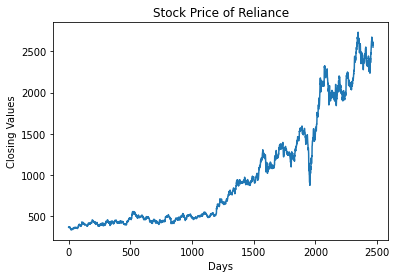

In [131]:
plt.plot(stockdata)
#plt.legend(loc='lower right')
plt.title('Stock Price of Reliance')
plt.xlabel('Days')
plt.ylabel('Closing Values')


Text(0.5, 1.0, 'Volume of shares traded')

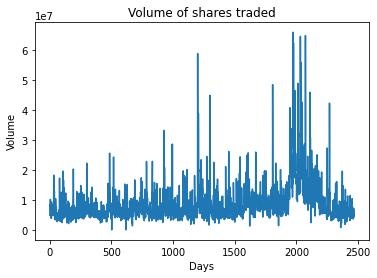

In [134]:
plt.plot(plotdata['Volume'])
plt.xlabel('Days')
plt.ylabel('Volume')
plt.title('Volume of shares traded')

Text(0.5, 1.0, 'NIFTY Index')

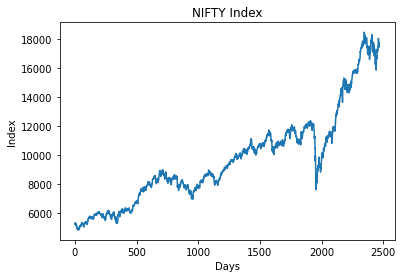

In [136]:
plt.plot(plotdata['NifClose'])
plt.xlabel('Days')
plt.ylabel('Index')
plt.title('NIFTY Index')

Text(0.5, 1.0, 'INR vs USD')

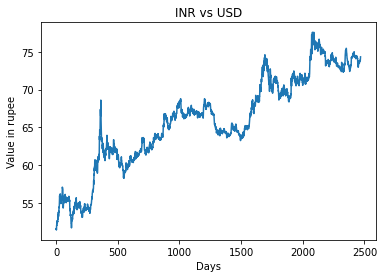

In [137]:
plt.plot(plotdata['CurClose'])
plt.xlabel('Days')
plt.ylabel('Value in rupee')
plt.title('INR vs USD')

#### Feature Scaling 

In [96]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc = MinMaxScaler(feature_range=(0,1))
stockdata =sc.fit_transform(np.array(stockdata).reshape(-1,1))

### Splitting the dataset

In [138]:
splitRatio = 0.6
trainSize=int(len(stockdata)*splitRatio)
testSize=len(stockdata)-trainSize
trainData,testData = stockdata[0:trainSize,:], stockdata[trainSize:len(stockdata),:1]

KeyError: 'key of type tuple not found and not a MultiIndex'

In [98]:
trainSize ,testSize

(1481, 988)

#### Function for creating Dataset Matrix 

In [99]:
def create_dataset(dataset, timeStep=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-timeStep-1):
		a = dataset[i:(i+timeStep), 0]   
		dataX.append(a)
		dataY.append(dataset[i + timeStep, 0])
	return np.array(dataX), np.array(dataY)

In [101]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
timeStep = 100
X_train, y_train = create_dataset(trainData, timeStep)
X_test, y_test = create_dataset(testData, timeStep)

In [76]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

## Creating Stacked LSTM Model

In [102]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [118]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [104]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_18 (LSTM)              (None, 100, 25)           7600      
                                                                 
 lstm_19 (LSTM)              (None, 25)                5100      
                                                                 
 dense_6 (Dense)             (None, 1)                 26        
                                                                 
Total params: 23,126
Trainable params: 23,126
Non-trainable params: 0
_________________________________________________________________


In [119]:
#fitting the model
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size = 64)

Epoch 1/200
22/22 [==============================] - 16s 313ms/step - loss: 0.0016 - val_loss: 0.0035
Epoch 2/200
22/22 [==============================] - 4s 182ms/step - loss: 1.7551e-04 - val_loss: 0.0028
Epoch 3/200
22/22 [==============================] - 5s 207ms/step - loss: 1.0037e-04 - val_loss: 0.0037
Epoch 4/200
22/22 [==============================] - 4s 181ms/step - loss: 9.1197e-05 - val_loss: 0.0035
Epoch 5/200
22/22 [==============================] - 4s 187ms/step - loss: 9.0721e-05 - val_loss: 0.0041
Epoch 6/200
22/22 [==============================] - 4s 188ms/step - loss: 8.7614e-05 - val_loss: 0.0038
Epoch 7/200
22/22 [==============================] - 4s 186ms/step - loss: 8.6929e-05 - val_loss: 0.0034
Epoch 8/200
22/22 [==============================] - 4s 183ms/step - loss: 8.5582e-05 - val_loss: 0.0048
Epoch 9/200
22/22 [==============================] - 4s 186ms/step - loss: 8.4480e-05 - val_loss: 0.0053
Epoch 10/200
22/22 [==============================] - 5s 2

In [120]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [121]:
#Transforming back to original form 
train_predict = sc.inverse_transform(train_predict)
test_predict  = sc.inverse_transform(test_predict)


#### Evalutaing Accuracy of the Model

In [122]:
import math
from sklearn.metrics import mean_squared_error , r2_score, mean_absolute_error
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test,test_predict)))
print("R2 Score:",r2_score(test_predict, y_test))
print("MAE:",mean_absolute_error(test_predict, y_test))

Root Mean Squared Error: 0.03571211788342974
R2 Score: 0.962280179640703
MAE: 0.026944326690062227


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


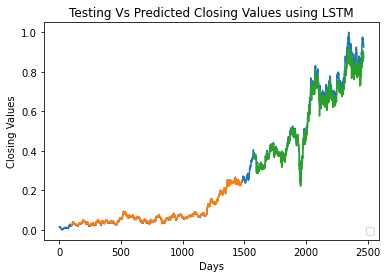

In [123]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(stockdata)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(stockdata)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(stockdata)-1, :] = test_predict
# plot baseline and predictions
plt.plot(sc.inverse_transform(stockdata))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.xlabel('Days')
plt.ylabel('Closing Values')
plt.legend(loc='lower right')
plt.title('Testing Vs Predicted Closing Values using LSTM')
plt.show()